# Random Forrest --- predict Failure Mode #
# UCI dataset "AI4I 2020 Predictive Maintenance Dataset Data Set" #

Online-Source [here](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset#)

 AI4I 2020 Predictive Maintenance Dataset Data Set
Download: Data Folder, Data Set Description

Abstract: The AI4I 2020 Predictive Maintenance Dataset is a synthetic dataset that reflects real predictive maintenance data encountered in industry.

| | | | | | |	
|:---|:---:|:---|:---:|:---|:---:|
|Data Set Characteristics: |Multivariate, Time-Series |Number of Instances: |10.000 |Area: |Computer |
|Attribute Characteristics: |Real |Number of Attributes: |14 | Date Donated: | 2020-08-30 |
|Associated Tasks: | Classification, Regression, Causal-Discovery | Missing Values? |N\A|Number of Web Hits: | 16614 |


Source:

Stephan Matzka, School of Engineering - Technology and Life, Hochschule für Technik und Wirtschaft Berlin, 12459 Berlin, Germany, stephan.matzka '@' htw-berlin.de

Data Set Information:

Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic dataset that reflects real predictive maintenance encountered in industry to the best of our knowledge.




Attribute Information:

The dataset consists of 10 000 data points stored as rows with 14 features in columns <br>
<b> UID : </b> unique identifier ranging from 1 to 10000<br>
<b> product ID: </b>consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number <br>
<b> air temperature [K]: </b> generated using a random walk process later normalized to a standard deviation of 2 K around 300 K <br>
<b> process temperature [K]: </b> generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K. <br>
<b> rotational speed [rpm]: </b> calculated from a power of 2860 W, overlaid with a normally distributed noise <br>
<b> torque [Nm]: </b> torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values. <br>
<b> tool wear [min]: </b> The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process. and a
'machine failure' label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true. <br>

The machine failure consists of five independent failure modes <br>
<b> tool wear failure (TWF): </b> the tool will be replaced or fail at a randomly selected tool wear time between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned). <br>
<b> heat dissipation failure (HDF): </b> heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm. This is the case for 115 data points. <br>
<b> power failure (PWF): </b> the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset. <br>
<b> overstrain failure (OSF): </b> if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints. <br>
<b> random failures (RNF): </b> each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.<br>
<br>
If at least one of the above failure modes is true, the process fails and the 'machine failure' label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail

Relevant Papers:

Stephan Matzka, 'Explainable Artificial Intelligence for Predictive Maintenance Applications', Third International Conference on Artificial Intelligence for Industries (AI4I 2020), 2020 (in press)


Citation Request:

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science. 

# <b> What is done in this notebook? </b> #
Every data record contains information on the failure and the failure mode.
In this notebook we try to predict, which failure mode applies to a given record.

To this end we chose a subset of features of the dataset and use:
1. a decisiontree 
2. a random forrest
3. a Gradientboosting classifier

## Plan: ##
1. enhance the failue modes by a new one: NOF - no failure. Thus a predictor has the possibility to move probability mass to this mode in case of no failure.
2. construct a random forrest 
3. determine the best size of the forrest measured by AUC


# Accuracy is not the correct metric #
Machine failure is a rare event, i.e. accuracy is no meaningful performace-measure since a classifier allways predicting "No Machine Failure" will have a high accurcy without being usefull at all.<br>
We use:<br>
+ AUC area under (ROC) curve ---


In [20]:
%reset -f

In [21]:
import pandas as pd
import os
from pathlib import Path
import numpy as np

In [22]:
# define a dictionary to collect all relevant results on the way:
#=================================================================
REPORT = {}

In [23]:
# READ THE DATASET INTO A DATAFRAME:
# ==================================

# use absolute path:

#base_path = Path("C:/Users/BoSc/Documents/1000_Machine_Learning/1000_UCI_datasets/predictive_maintenance_dataset")
#csv_data_file_path = Path("/dataset/ai4i2020.csv")
#df = pd.read_csv(os.path.join(base_path, csv_data_file_path))

# use path relative to the notebook:

csv_data_file_path = Path("./dataset/ai4i2020.csv")
df = pd.read_csv(csv_data_file_path)

REPORT["csv_data_file_path"] = "./dataset/ai4i2020.csv"

In [24]:
# TAKE A LOOK AT THE DATA:
# ========================

df[:3]

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0


In [25]:
# start by dealing with only one quality of equipment: l or h or m:
#==================================================================
from sklearn.preprocessing import OneHotEncoder

equipment_type = 'all'
#equipment_type = 'L'
#equipment_type = 'M'
#equipment_type = 'H'

REPORT["equipment_type"] = equipment_type

data_columns = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
    'Machine failure',
    'TWF',
    'HDF', 
    'PWF', 
    'OSF',
    'RNF',
    ]

if(equipment_type != 'all'):
    df_ = df[df['Type']== equipment_type]
else:
    df_ = df
    df_type = df['Type']
    df_type = df_type.values.reshape(-1,1)
    enc = OneHotEncoder(sparse=False)
    ohe_type= enc.fit_transform(df_type)
    df_.insert(0, "L", ohe_type[:,1])
    data_columns.insert(0,"L")
    df_.insert(1, "M", ohe_type[:,2])
    data_columns.insert(1, "M")
    df_.insert(2, "H", ohe_type[:,0])
    data_columns.insert(2, "H")

data_df = df_[data_columns]
REPORT["data_columns"] = data_columns
data_df[:3]

,L,M,H,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0.0,1.0,0.0,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,1.0,0.0,0.0,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,1.0,0.0,0.0,298.1,308.5,1498,49.4,5,0,0,0,0,0,0


In [26]:
# PREPARE DATA AND LABELS:
# ========================

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

predictive_columns = data_columns[:-6]
X = data_df[predictive_columns]
target_columns = data_columns[-6:]
y = data_df[target_columns]


In [27]:
# Some sanity-check of the data to avoid single-class training-/test-sets:
#=========================================================================

# check if there are some records for machine-failure in the data:
print(f"There are approximately {np.asarray(y == 1).sum() / 2 } records for machine failure in the data: ")

There are approximately 356.0 records for machine failure in the data: 


In [28]:
# Train-test split of the data:

test_size=0.2
REPORT["test_size"] = test_size

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0, test_size=test_size)
print(X.shape)
REPORT["X.shape"]= X.shape
print(y.shape)
REPORT["y.shape"]=y.shape
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(predictive_columns)
print(target_columns)


(10000, 8)
(10000, 6)
(8000, 8)
(8000, 6)
(2000, 8)
(2000, 6)
['L', 'M', 'H', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']


In [29]:
# Some sanity-check of the data to avoid single-class training-/test-sets:
#=========================================================================

# check if there are some records for machine-failure in the data:
print(f"There are approximately {np.asarray(y_train == 1).sum() / 2 } machine-failure records in the train set")
print(f"There are approximately {np.asarray(y_test ==1).sum() /2 } machine-failure records in the test set")

There are approximately 280.0 machine-failure records in the train set
There are approximately 76.0 machine-failure records in the test set


# Decision Tree: #

In [30]:
# DEFINE AND FIT DECISION-TREE:
# =============================

from sklearn.tree import DecisionTreeClassifier

max_graph_depth=6
tree_clf = DecisionTreeClassifier(max_depth=max_graph_depth)
tree_clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=6)

In [31]:
# MEAN ACCURACY OF THE TEST DATA:
# ===============================

# this does not say much, since we have mainly "0" as labels:
mean_acc = tree_clf.score(X_test, y_test)
REPORT["mean acc single tree"]=mean_acc
print(f"\n Mean accuracy: {mean_acc}")



 Mean accuracy: 0.972


In [33]:
# ROC-AUC METRIC FOR DATASET WITH CLASS IMBALANCE:
#=================================================
# see e.g.:Data School vid on roc auc: https://youtu.be/OAl6eAyP-yo

from sklearn.metrics import roc_auc_score

y_preds = tree_clf.predict(X_test)
auc=roc_auc_score(y_test, y_preds)
REPORT["auc single tree"]=auc

print(f"\n Area Under the Curve (auc): {auc}")


 Area Under the Curve (auc): 0.6833586074647383


# Visualize the decision-tree as a graph: #
1. Run the next cell: a file will be saved in your folder named "machine_tree_depth{max_graph_depth}.dot". 
2. Open this file in VSCode or in Microsoft Word or Notepad++ and copy all of its content. 
3. Open the browser, search for "webgraphviz", or use [this](http://www.jdolivet.byethost13.com/Logiciels/WebGraphviz/?i=1)

4. Delete whatever is written in white space and paste the copied content from step 2.
5. Click "generate graph". 
5. Scroll down to find the graph: left mouse button "take screen-shot" -> paste into irfan view-> safe as .jpg in the project folder

6. Either display the jpg inside the notebook or open (double-click) inside VS Code (opens in new tab).

In [34]:
# the following code can be used to generate a visualisation of the decisiontree as a graph - see preceding text:
#================================================================================================================
from sklearn.tree import export_graphviz

out_file_name=f"machine_tree_depth{max_graph_depth}"
REPORT["file name graph viz"]=out_file_name

export_graphviz( 
    tree_clf,
    out_file=out_file_name,
    feature_names=predictive_columns,
    class_names=["No Machine Failure", "Machine Failure"],
    rounded= True,
    filled=True
    )

# Random Forrest Classifier: #

In [59]:
# Random Forrest Classifier:
#==============================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

n_estimators = []

def rf_auc(n_estimators, X_train, X_test, y_train, y_test):
    """
        The function trains a random-forrest for each number of trees given in the n_estimators list and determines it's auc-score on the X_test set.
        Input:
            n_estimators: a list of numbers specifying the number of estimators (trees) in the forrests.
            X_train: training set of samples
            X_test: test set of samples
            y_train: training set of labels
            y_test: test set of labels
        Output:
            a list of auc-scores
            a list of acccuracies
            the best classifier: according to the auc criterium
            best_preds: the list of predictions of the auc-best random-forrest predictor
            maxAuc: the auc of the auc-best classifier
            accOfBest: the accuracy of the auc-best classifier

    """
    aucs=[]
    accuracies=[]
    best_preds = []
    maxAuc = 0
    for nofest in n_estimators:
        rnd_clf = RandomForestClassifier(n_estimators=nofest, max_leaf_nodes=None, n_jobs=-1, random_state=42)
        rnd_clf.fit(X_train,y_train)
        y_pred = rnd_clf.predict(X_test)
        acc = rnd_clf.score(X_test, y_test.values)
        accuracies.append(acc)
        rocAuc = roc_auc_score(y_test.values, y_pred)
        aucs.append(rocAuc)
        if(rocAuc > maxAuc):
            maxAuc = rocAuc
            best_preds = y_pred
            accOfBest = acc
            best_clf = rnd_clf

    return aucs, accuracies, best_clf, best_preds, maxAuc, accOfBest

# compare with the single decision-tree of the previous solution above:
auc, acc, _, _, _, _ = rf_auc([1],  X_train, X_test, y_train, y_test)
REPORT["auc single tree forrest"]=auc
REPORT["acc single tree forrest"]=acc
print(f"\n Equipment Type: {equipment_type}")
print(f"\n auc: {auc}")
print(f"\n accuracy: {acc}")
#for i in range(len(truth)):
#    if( truth[i].sum() > 0 or preds[i].sum() > 0):
#        print(f"\n {truth[i]} -- {preds[i]}")


 Equipment Type: all

 auc: [0.7153833128368995]

 accuracy: [0.9625]


In [111]:
rnd_clf = RandomForestClassifier(n_estimators=2, max_leaf_nodes=None, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train,y_train)
y_pred = rnd_clf.predict(X_test)
rocAuc = roc_auc_score(y_test.values, y_pred)


In [114]:
print(type(y_test.values))
print(type(y_pred))
print(y_test.values, y_pred)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]] [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


In [36]:
# Try to find the best number of estimators (trees in the forrest):
#==================================================================
import numpy as np

n_estimators = np.arange(100, 1000, 100)
aucs, accs, best_classifier, best_preds, bestAUC, accOfBest = rf_auc(n_estimators, X_train, X_test, y_train, y_test)
REPORT["auc best forrest"]=bestAUC
REPORT["acc best forrest"]=accOfBest

aucp = np.array(aucs)
accp = np.array(accs)


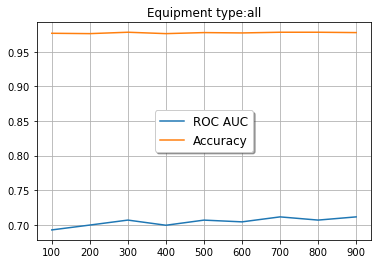

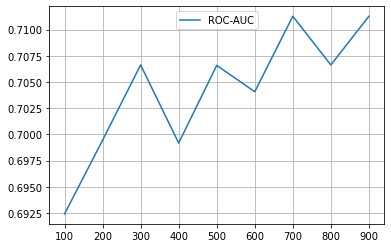

In [37]:
# Plot the auc-scores over the number of trees in the random-forrest:
#====================================================================
import matplotlib.pyplot as plt 

_, ax = plt.subplots()
ax.plot(n_estimators, aucp, label="ROC AUC")
ax.plot(n_estimators, accp, label="Accuracy")
ax.grid()
ax.legend(loc='center', shadow=True, fontsize='large')
plt.title(f"Equipment type:{equipment_type}")
plt.show()

_, ax = plt.subplots()
ax.plot(n_estimators, aucp, label="ROC-AUC")
ax.legend(loc="upper center", fontsize="medium")
ax.grid()
plt.show()

In [38]:
# find the best choice for the number of estimators by calculation:
#==================================================================
best_nof_estimators = n_estimators[np.argmax(aucp)]
REPORT["Number of estimators best forrest"]=best_nof_estimators
best_accuracy = np.max(accp)
worst_accuracy = np.min(accp)
REPORT["Best accuracy of all forrests"]=best_accuracy
REPORT["Worst accuracy of all forrests"]=worst_accuracy
print(f"max auc: {np.max(aucp)}, with {best_nof_estimators} estimators, having accuracy of: {accOfBest} ")
print(f"\nbest_accuracy: {best_accuracy}, worst_accuracy: {worst_accuracy}")

max auc: 0.7112718922992842, with 700 estimators, having accuracy of: 0.9785 

best_accuracy: 0.9785, worst_accuracy: 0.9765


In [39]:
print(REPORT)

{'csv_data_file_path': './dataset/ai4i2020.csv', 'equipment_type': 'all', 'data_columns': ['L', 'M', 'H', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], 'test_size': 0.2, 'X.shape': (10000, 8), 'y.shape': (10000, 6), 'mean acc single tree': 0.972, 'auc single tree': 0.6833586074647383, 'file name graph viz': 'machine_tree_depth6', 'auc single tree forrest': [0.7124684235514271], 'acc single tree forrest': [0.979], 'auc best forrest': 0.7112718922992842, 'acc best forrest': 0.9785, 'Number of estimators best forrest': 700, 'Best accuracy of all forrests': 0.9785, 'Worst accuracy of all forrests': 0.9765}


In [50]:
# feature importance for the best performing forrest:

for name, score in zip(data_columns, best_classifier.feature_importances_):
    print(name, '{:.2f}'.format(score))

L 0.01
M 0.01
H 0.01
Air temperature [K] 0.13
Process temperature [K] 0.12
Rotational speed [rpm] 0.24
Torque [Nm] 0.31
Tool wear [min] 0.17


## Summary: ##
1. The number of estimators in the best random-forrest is not a constant, maybe due to the random feature selection in the decision-tree algorithm used by scikit.
2. The auc of the random-forrest is higher than the auc of a single decision tree.
3. The best and the worst accuracy are almost identical, proving once more, that accuracy is not usefull in this heavily unbalanced data-set.
4. The best random-forrest measured by auc is not necessarily the best measured by accuracy.
5. Running the rf_auc function several times, we find that the best number of estimators varies considerably.
6. The confusion matrix below shows the strong and weak points of the auc-best random-forrest


In [116]:
def OheToSingleCodedModes(ohe_labels, code="named"):
    """
        The failure-modes are OHE or rather (More-than-one-hot-) encoded.
        This function encodes them as integers (code="numeric") or like the column names (code="named"), 
        but takes only single-mode machine-failures correctly into account.
        Multi-mode machine-failures are jointly encoded as "NonStandardMode".
        
        Input:
            ohe_labels: an array of arrays of zero and ones
            code: target encoding - default = "named"=column names of the original dataframe, 
                                    "numeric" = integers
        Output:
            an array of integers.
    """
    coded_modes = []
    if(code == "numeric"):
        # ...this was intended for stratified train-test-split...
        # build a mode dictionary for the standard failure modes (given in the explantion above). 
        # No multi-mode failures are accounted for:
        modes = {"".join(map(str,[0,0,0,0,0,0])): 0, #'No Machine failure',
            "".join(map(str,[1,1,0,0,0,0])): 1, #'TWF',
            "".join(map(str,[1,0,1,0,0,0])): 2, #'HDF', 
            "".join(map(str,[1,0,0,1,0,0])): 3, #'PWF', 
            "".join(map(str,[1,0,0,0,1,0])): 4, #'OSF',
            "".join(map(str,[0,0,0,0,0,1])): 5,#'RNF',
        }
        # machine failures consisting of multiple modes are designated as "NonStandardMode":
        for v in ohe_labels:
            coded_modes.append(modes.get("".join(map(str,v)), 6)) # 6  =="NonStandardMode"
    else:
        modes = {"".join(map(str,[0,0,0,0,0,0])): 'No Machine failure',
            "".join(map(str,[1,1,0,0,0,0])): 'TWF',
            "".join(map(str,[1,0,1,0,0,0])): 'HDF', 
            "".join(map(str,[1,0,0,1,0,0])): 'PWF', 
            "".join(map(str,[1,0,0,0,1,0])): 'OSF',
            "".join(map(str,[0,0,0,0,0,1])): 'RNF',
        }
        # machine failures consisting of multiple modes are designated as "NonStandardMode":
        for v in ohe_labels:
            coded_modes.append(modes.get("".join(map(str,v)),"NonStandardMode")) 

    return coded_modes

# clear mode dictionary:
clear_modes =  {
    0 : 'No Machine failure',
    1 : 'TWF',
    2 : 'HDF', 
    3 : 'PWF', 
    4 : 'OSF',
    5 : 'RNF',
    6 : "NonStandardMode",
}

modes_OHE = {
    0 : [0,0,0,0,0,0], # 'No Machine failure
    1 : [1,1,0,0,0,0], # 'TWF'
    2 : [1,0,1,0,0,0], # 'HDF' 
    3 : [1,0,0,1,0,0], # 'PWF' 
    4 : [1,0,0,0,1,0], # 'OSF'
    5 : [0,0,0,0,0,1], # 'RNF'
    6 : [1,1,1,0,0,0], # 'NonStandardMode'
}

In [ ]:
# plot a confusion matrix for the random-forrest classifier:
#============================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_modes = OheToSingleCodedModes(y_test.values, code="named")
pred_modes = OheToSingleCodedModes(best_preds, code="named")

labels = ['No Machine failure','TWF','HDF','PWF','OSF','RNF',"NonStandardMode"]


# PLOT THE CONFUSION MATRIX WITH THE NEXT CELL

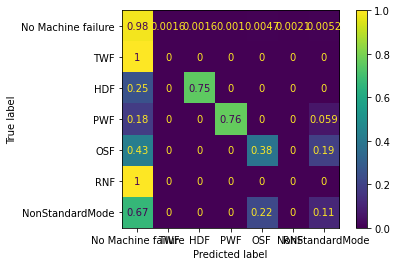

In [78]:
# chose a mode of presentation of the confusion matrix:
cm = confusion_matrix(true_modes, pred_modes, labels = labels, normalize="true") # row - normalization
#cm = confusion_matrix(true_modes, pred_modes, labels = labels, normalize="pred") # column -normalization
#cm = confusion_matrix(true_modes, pred_modes, labels = labels, normalize="all") # over all entries - normalization
#cm = confusion_matrix(true_modes, pred_modes, labels = labels, normalize=None) # absolute numbers
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
#disp.ax_.set_title(f"Equipment type: {equipment_type}") # seems to be possible in scikit v1.0
disp.plot()

In [122]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

def gbc_auc(n_estimators, X_train, X_test, y_train, y_test):
    """
        The function trains a random-forrest for each number of trees given in the n_estimators list and determines it's auc-score on the X_test set.
        Input:
            n_estimators: a list of numbers specifying the number of estimators (trees) in the forrests.
            X_train: training set of samples
            X_test: test set of samples
            y_train: training set of labels
            y_test: test set of labels
        Output:
            a list of auc-scores
            a list of acccuracies
            the best classifier: according to the auc criterium
            best_preds: the list of predictions of the auc-best random-forrest predictor
            maxAuc: the auc of the auc-best classifier
            accOfBest: the accuracy of the auc-best classifier

    """
    aucs=[]
    accuracies=[]
    best_preds = []
    maxAuc = 0
    y_train_num = OheToSingleCodedModes(y_train.values, code='numeric')
    y_test_num = np.array(OheToSingleCodedModes(y_test.values, code='numeric'))
    
    for nofest in n_estimators:
        gb_clf = GradientBoostingClassifier(n_estimators=nofest, random_state=42)
        gb_clf.fit(X_train,y_train_num)
        y_pred = gb_clf.predict(X_test)
        
        acc = gb_clf.score(X_test, y_test_num)
        accuracies.append(acc)

        yp_ohe = [modes_OHE[n] for n in y_pred]
        rocAuc = roc_auc_score(y_test.values, yp_ohe)
        aucs.append(rocAuc)

        if(rocAuc > maxAuc):
            maxAuc = rocAuc
            best_preds = yp_ohe
            accOfBest = acc
            best_clf = rnd_clf

    return aucs, accuracies, best_clf, best_preds, maxAuc, accOfBest

# compare with the single decision-tree of the previous solution above:
auc, acc, _, _, _, _ = gbc_auc([1],  X_train, X_test, y_train, y_test)
REPORT["auc single tree gradientboost forrest"]=auc
REPORT["acc single tree gradientboost forrest"]=acc
print(f"\n Equipment Type: {equipment_type}")
print(f"\n auc: {auc}")
print(f"\n accuracy: {acc}")
#for i in range(len(truth)):
#    if( truth[i].sum() > 0 or preds[i].sum() > 0):
#        print(f"\n {truth[i]} -- {preds[i]}")


 Equipment Type: all

 auc: [0.6908578770328067]

 accuracy: [0.9705]


In [126]:
# Try to find the best number of GradientBoostingClassifier estimators (trees in the forrest):
#=============================================================================================
import numpy as np

#n_estimators = np.arange(100, 1000, 100)
n_estimators=[100]
gb_aucs, gb_accs, gb_best_classifier, gb_best_preds, gb_bestAUC, gb_accOfBest = gbc_auc(n_estimators, X_train, X_test, y_train, y_test)
REPORT["auc best gradientboost forrest"]=gb_bestAUC
REPORT["acc best gradientboost forrest"]=gb_accOfBest

gb_aucp = np.array(gb_aucs)
gb_accp = np.array(gb_accs)

In [127]:
# find the best choice for the number of estimators by calculation:
#==================================================================
gb_best_nof_estimators = n_estimators[np.argmax(gb_aucp)]
REPORT["Number of estimators best gradientboost forrest"]=gb_best_nof_estimators
gb_best_accuracy = np.max(gb_accp)
gb_worst_accuracy = np.min(gb_accp)
REPORT["Best accuracy of all gradientboost forrests"]=gb_best_accuracy
REPORT["Worst accuracy of all gradientboost forrests"]=gb_worst_accuracy
print(f"max auc: {np.max(gb_aucp)}, with {gb_best_nof_estimators} estimators, having accuracy of: {gb_accOfBest} ")
print(f"\nbest_accuracy: {gb_best_accuracy}, worst_accuracy: {gb_worst_accuracy}")

max auc: 0.6882957680268058, with 100 estimators, having accuracy of: 0.9725 

best_accuracy: 0.9725, worst_accuracy: 0.9725


In [133]:
# plot a confusion matrix for the GradientBoostingClassifier classifier:
#============================================================
gb_pred_modes = OheToSingleCodedModes(gb_best_preds, code='named')
gb_true_modes = OheToSingleCodedModes(y_test.values, code="named")

labels = ['No Machine failure','TWF','HDF','PWF','OSF','RNF',"NonStandardMode"]

# PLOT THE CONFUSION MATRIX WITH THE NEXT CELL

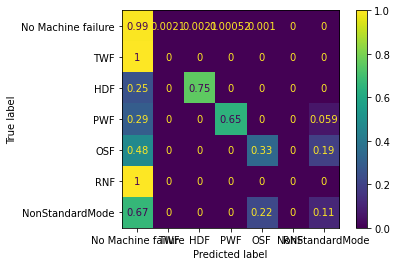

In [135]:
# chose a mode of presentation of the confusion matrix:
#======================================================
cm = confusion_matrix(gb_true_modes, gb_pred_modes, labels = labels, normalize="true") # row - normalization
#cm = confusion_matrix(gb_true_modes, gb_pred_modes, labels = labels, normalize="pred") # column -normalization
#cm = confusion_matrix(gb_true_modes, gb_pred_modes, labels = labels, normalize="all") # over all entries - normalization
#cm = confusion_matrix(gb_true_modes, gb_pred_modes, labels = labels, normalize=None) # absolute numbers
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()